In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

In [2]:
# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()  # Output values between 0-1
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [4]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=20).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)  # Flatten images
        
        # Forward pass
        reconstructed, latent = model(img)
        loss = criterion(reconstructed, img)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/15], Loss: 0.0269
Epoch [2/15], Loss: 0.0224
Epoch [3/15], Loss: 0.0193
Epoch [4/15], Loss: 0.0184
Epoch [5/15], Loss: 0.0165
Epoch [6/15], Loss: 0.0138
Epoch [7/15], Loss: 0.0127
Epoch [8/15], Loss: 0.0117
Epoch [9/15], Loss: 0.0138
Epoch [10/15], Loss: 0.0109
Epoch [11/15], Loss: 0.0113
Epoch [12/15], Loss: 0.0115
Epoch [13/15], Loss: 0.0107
Epoch [14/15], Loss: 0.0123
Epoch [15/15], Loss: 0.0114


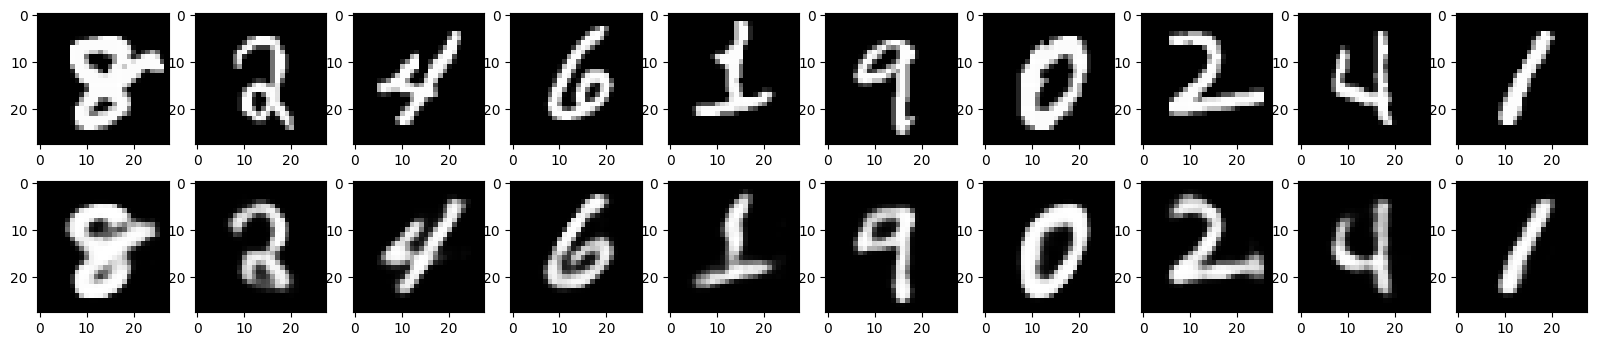

In [6]:
# Demonstrate the reconstruction quality of the latent space
# (top row is MNIST source and the bottom is latent space)
def show_reconstructions(model, n=10):
    model.eval()
    with torch.no_grad():
        data = next(iter(train_loader))
        img = data[0][:n]
        img_flattened = img.view(n, -1).to(device)
        reconstructed, _ = model(img_flattened)
        
        fig, axes = plt.subplots(2, n, figsize=(20, 4))
        for i in range(n):
            axes[0][i].imshow(img[i].squeeze(), cmap='gray')
            axes[1][i].imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.show()
show_reconstructions(model)

In [7]:
# Visualize latent space using PCA
def plot_latent_space_pca(model, data_loader, device):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data in data_loader:
            img, label = data
            img = img.view(img.size(0), -1).to(device)
            _, latent = model(img)
            latents.append(latent.cpu())
            labels.append(label)
    
    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latents)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title('Latent Space Visualization (PCA)')
    plt.show()

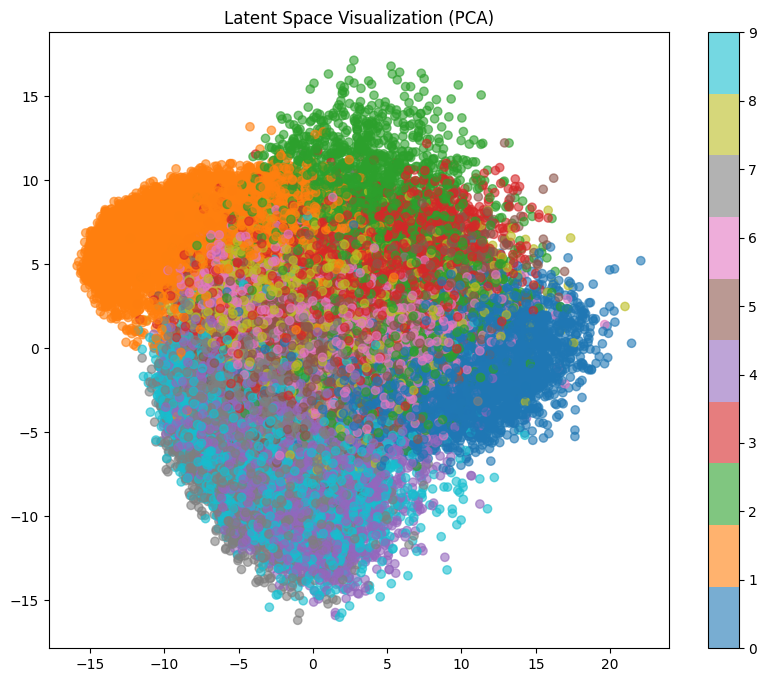

In [8]:
# Plot latent space using PCA
plot_latent_space_pca(model, train_loader, device)

In [11]:
import umap

def plot_latent_space_umap(model, data_loader, device):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data in data_loader:
            img, label = data
            img = img.view(img.size(0), -1).to(device)
            _, latent = model(img)
            latents.append(latent.cpu())
            labels.append(label)
    
    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # Use UMAP instead of PCA
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=20,       # Controls local vs global structure
        min_dist=0.1,         # Controls cluster tightness
        metric='euclidean',   # Distance metric
        random_state=42
    )
    latent_2d = reducer.fit_transform(latents)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title('Latent Space Visualization (UMAP)')
    plt.show()

/home/ebljohn/github/booli/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ebljohn/github/booli/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


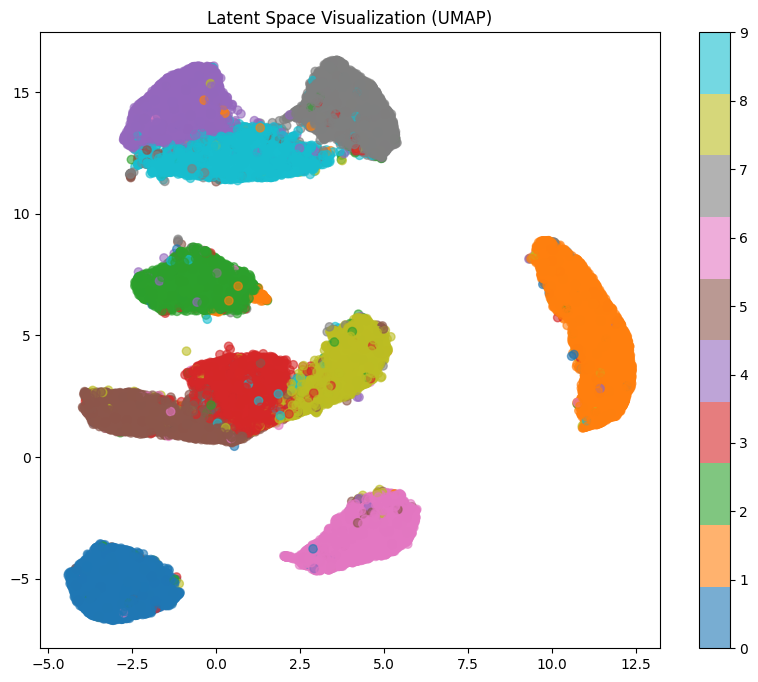

In [12]:
# Plot latent space using UMAP
plot_latent_space_umap(model, train_loader, device)